In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
import pandas_datareader as pdr
from simulation.simulation import simulate_normal_returns, alpha_stable_sampler_QMC

%load_ext autoreload
%autoreload 2

In [2]:
# TO DO : i) entrainer le LSTM ii) calculer les poids optimaux et ploter

## 1) Loading market data 

In [3]:
tickers_cac40 = [
    "ACC.PA",  # Accor
    "AI.PA",   # Air Liquide
    "AIR.PA",  # Airbus Group
    "MT.AS",   # ArcelorMittal
    "CS.PA",   # AXA
    "BNP.PA",  # BNP Paribas
    "EN.PA",   # Bouygues
    "CAP.PA",  # Capgemini
    "CA.PA",   # Carrefour
    "ACA.PA",  # Crédit Agricole
    "BN.PA",   # Danone
    "DSY.PA",  # Dassault Systèmes
    "EDEN.PA", # Edenred
    "ENGI.PA", # Engie
    "EL.PA",   # EssilorLuxottica
    "ERF.PA",  # Eurofins Scientific
    "RMS.PA",  # Hermès International
    "KER.PA",  # Kering
    "LR.PA",   # Legrand
    "OR.PA",   # L'Oréal
    "MC.PA",   # LVMH
    "ML.PA",   # Michelin
    "ORA.PA",  # Orange
    "RI.PA",   # Pernod Ricard
    "PUB.PA",  # Publicis Groupe
    "RNO.PA",  # Renault
    "SAF.PA",  # Safran
    "SGO.PA",  # Saint-Gobain
    "SAN.PA",  # Sanofi
    "SU.PA",   # Schneider Electric
    "GLE.PA",  # Société Générale
    "STLA.PA", # Stellantis
    "STM.PA",  # STMicroelectronics
    "TEP.PA",  # Téléperformance
    "HO.PA",   # Thales
    "TTE.PA",  # TotalEnergies
    "URW.PA",  # Unibail-Rodamco-Westfield
    "VIE.PA",  # Veolia Environnement
    "DG.PA",   # Vinci
    "VIV.PA"   # Vivendi
]

tickers_cac40_dict = {
    "ACC.PA": "Accor",
    "AI.PA": "Air Liquide",
    "AIR.PA": "Airbus Group",
    "MT.AS": "ArcelorMittal",
    "CS.PA": "AXA",
    "BNP.PA": "BNP Paribas",
    "EN.PA": "Bouygues",
    "CAP.PA": "Capgemini",
    "CA.PA": "Carrefour",
    "ACA.PA": "Crédit Agricole",
    "BN.PA": "Danone",
    "DSY.PA": "Dassault Systèmes",
    "EDEN.PA": "Edenred",
    "ENGI.PA": "Engie",
    "EL.PA": "EssilorLuxottica",
    "ERF.PA": "Eurofins Scientific",
    "RMS.PA": "Hermès International",
    "KER.PA": "Kering",
    "LR.PA": "Legrand",
    "OR.PA": "L'Oréal",
    "MC.PA": "LVMH",
    "ML.PA": "Michelin",
    "ORA.PA": "Orange",
    "RI.PA": "Pernod Ricard",
    "PUB.PA": "Publicis Groupe",
    "RNO.PA": "Renault",
    "SAF.PA": "Safran",
    "SGO.PA": "Saint-Gobain",
    "SAN.PA": "Sanofi",
    "SU.PA": "Schneider Electric",
    "GLE.PA": "Société Générale",
    "STLA.PA": "Stellantis",
    "STM.PA": "STMicroelectronics",
    "TEP.PA": "Téléperformance",
    "HO.PA": "Thales",
    "TTE.PA": "TotalEnergies",
    "URW.PA": "Unibail-Rodamco-Westfield",
    "VIE.PA": "Veolia Environnement",
    "DG.PA": "Vinci",
    "VIV.PA": "Vivendi"
}

In [4]:
selected_tickers = [tickers_cac40[i] for i in [1,4,6,8]]
selected_tickers_names = [tickers_cac40_dict[key] for key in selected_tickers]
start_date = '2010-01-01'
interval = '1d'

market_data = yf.download(selected_tickers, start='2010-01-01', interval=interval)
market_data.index = market_data.index.tz_localize(None).floor('D')
# Pk utiliser la date comme ça sans jour?
#market_data["Date"] = market_data["Date"].dt.strftime('%Y/%m')
market_data = market_data[["Adj Close"]]
print(market_data.shape)
market_data.head()

[*********************100%***********************]  4 of 4 completed

(3834, 4)


Price       Adj Close                                
Ticker          AI.PA      CA.PA     CS.PA      EN.PA
Date                                                 
2010-01-04  30.840054  21.601980  7.704947  16.893999
2010-01-05  30.223251  22.113436  7.833361  17.101633
2010-01-06  30.037119  21.951420  7.913622  17.192904
2010-01-07  30.000622  21.703636  7.824190  16.957888
2010-01-08  30.095510  21.916483  7.849416  16.964733

## 2) Retrieving useful statistics

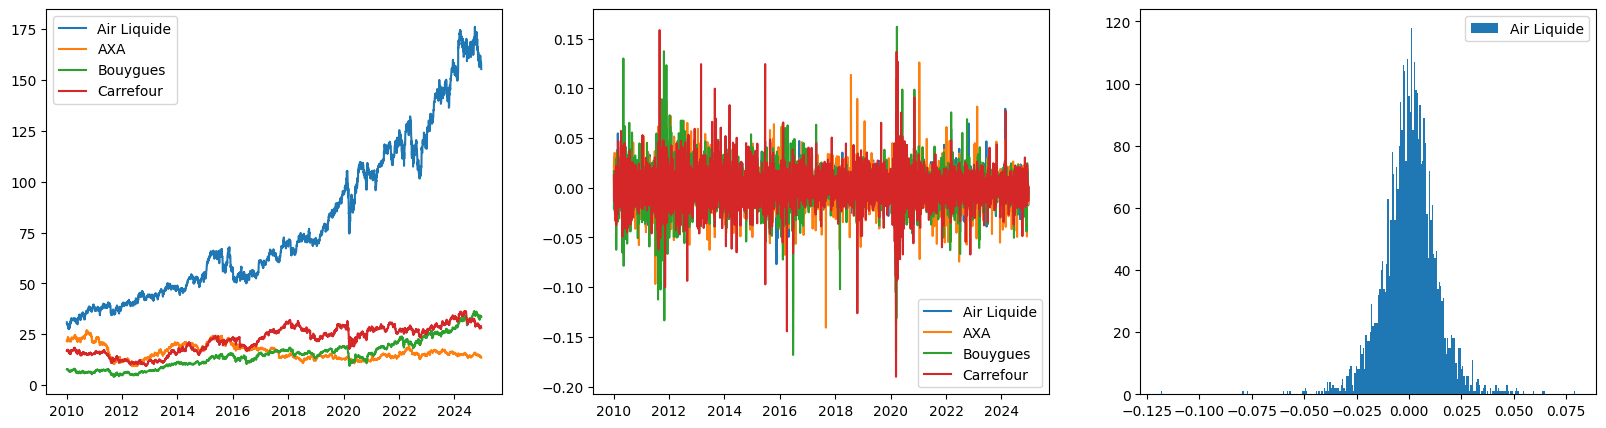

In [5]:
market_returns = np.log(market_data['Adj Close']) - np.log(market_data['Adj Close'].shift(1))
market_returns.dropna(inplace=True)
mean_returns = market_returns.mean()
mean_returns_value = mean_returns.values
cov_market = market_returns.cov() 
cov_market_values = cov_market.values

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(market_data['Adj Close'], label=selected_tickers_names)
plt.legend()
plt.subplot(132)
plt.plot(market_returns, label=selected_tickers_names)
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(market_returns.iloc[:,i], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

In [6]:
market_returns

Ticker,AI.PA,CA.PA,CS.PA,EN.PA
Date,,,,
2010-01-05,-0.020203,0.023400,0.016529,0.012215
2010-01-06,-0.006178,-0.007354,0.010194,0.005323
2010-01-07,-0.001216,-0.011352,-0.011365,-0.013764
2010-01-08,0.003158,0.009759,0.003219,0.000404
2010-01-11,-0.006204,-0.015042,-0.005272,0.009770
...,...,...,...,...
2024-12-16,-0.002508,-0.016167,-0.004114,-0.013507
2024-12-17,-0.002514,-0.004720,-0.006499,-0.005244
2024-12-18,-0.004036,0.001818,0.001777,0.001751


### 3) Simulating returns

In [7]:
np.random.seed(42)

In [8]:
# N correspond au nombre de timesteps (on est dans l'unité de la data originale, donc jour en l'occurence cf variable "interval" plus haut)
# La 2e dimension du tenseur donne les différentes simulations 
# la 3e au nombre d'assets

#N = le nbre de timsteps
N = market_returns.shape[0]
simulated_returns = simulate_normal_returns(mu=mean_returns_value, cov=cov_market_values, N= N, n_simul=10)
simulated_returns.shape

(3833, 10, 4)

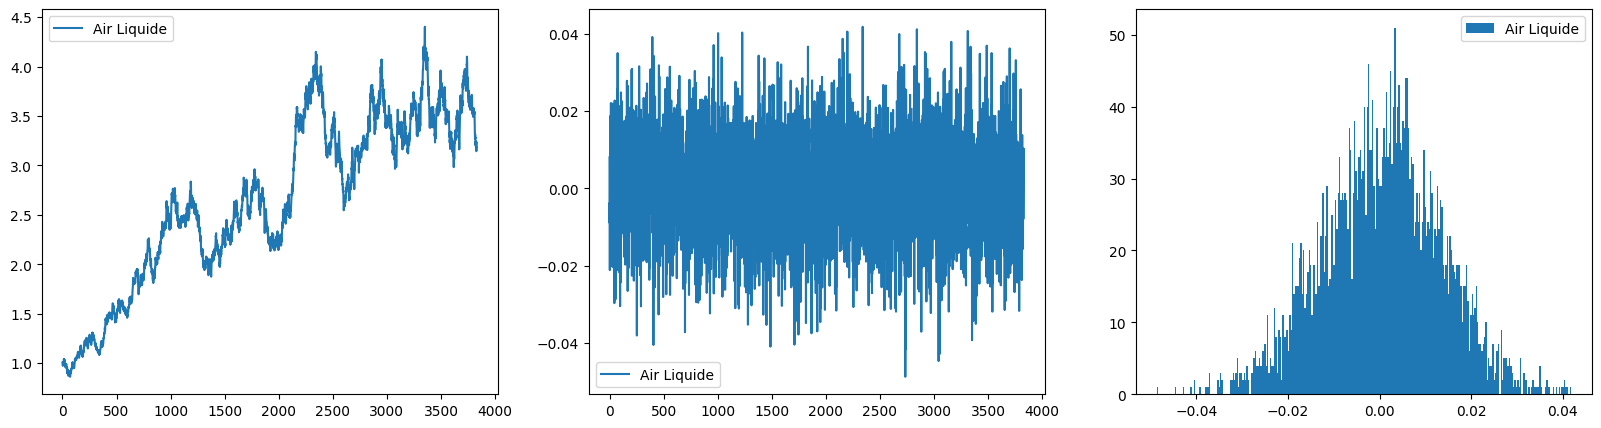

In [9]:
i = 0 
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(np.cumprod(1 + simulated_returns[:, i, 0]), label=selected_tickers_names[i])
plt.legend()
plt.subplot(132)
plt.plot(simulated_returns[:, i, 0], label=selected_tickers_names[i])
plt.legend()
plt.subplot(133)
i = 0 
plt.hist(simulated_returns[:, i, 0], label=selected_tickers_names[i], bins=300)
plt.legend()
plt.show()

## 3) Training the LSTM 

# Prblm : pk ça va pas jusqu'à la dernière date ?  fcts get training et test periods à modifier pour prendre toute la période peut etre

In [10]:
dates = market_data.index[:simulated_returns.shape[0]]  

single_simulation = simulated_returns[:, 0, :]

simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
simulation_df.index = dates[:len(simulation_df)]  

In [20]:
from models.base import NN_Sharpe
import torch 

input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)


In [21]:
from models.utils import training_with_model

num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.055466800928115845
epoch 1, loss = -0.05551930516958237
epoch 2, loss = -0.0555717833340168
epoch 3, loss = -0.05562424659729004
epoch 4, loss = -0.055676691234111786
epoch 5, loss = -0.055729128420352936
epoch 6, loss = -0.055781565606594086
epoch 7, loss = -0.05583398789167404
epoch 8, loss = -0.05588643625378609
epoch 9, loss = -0.05593888834118843
epoch 10, loss = -0.05599135905504227
epoch 11, loss = -0.05604385584592819
epoch 12, loss = -0.0560963936150074
epoch 13, loss = -0.0561489574611187
epoch 14, loss = -0.05620158836245537
epoch 15, loss = -0.05625426024198532
epoch 16, loss = -0.05630701780319214
epoch 17, loss = -0.05635984614491463
epoch 18, loss = -0.056412748992443085
epoch 19, loss = -0.056465744972229004
epoch 20, loss = -0.05651885271072388
epoch 21, loss = -0.05657206103205681
epoc

In [22]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.999084,0.000129,0.000579,0.000207,0.014850
2013-12-11,0.999084,0.000129,0.000579,0.000208,-0.000631
2013-12-12,0.999084,0.000129,0.000579,0.000208,0.023043
2013-12-13,0.999084,0.000129,0.000579,0.000208,-0.001398
2013-12-16,0.999084,0.000129,0.000579,0.000208,0.001131
...,...,...,...,...,...
2023-10-05,0.998544,0.000146,0.001023,0.000288,-0.022658
2023-10-06,0.998544,0.000146,0.001022,0.000288,0.007766
2023-10-09,0.998543,0.000146,0.001023,0.000288,0.029458


In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np


paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [24]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.999084,0.000129,0.000579,0.000207,0.014850,1.014850
2013-12-11,0.999084,0.000129,0.000579,0.000208,-0.000631,1.014210
2013-12-12,0.999084,0.000129,0.000579,0.000208,0.023043,1.037581
2013-12-13,0.999084,0.000129,0.000579,0.000208,-0.001398,1.036130
2013-12-16,0.999084,0.000129,0.000579,0.000208,0.001131,1.037302
...,...,...,...,...,...,...
2023-10-05,0.998544,0.000146,0.001023,0.000288,-0.022658,2.665652
2023-10-06,0.998544,0.000146,0.001022,0.000288,0.007766,2.686355
2023-10-09,0.998543,0.000146,0.001023,0.000288,0.029458,2.765490


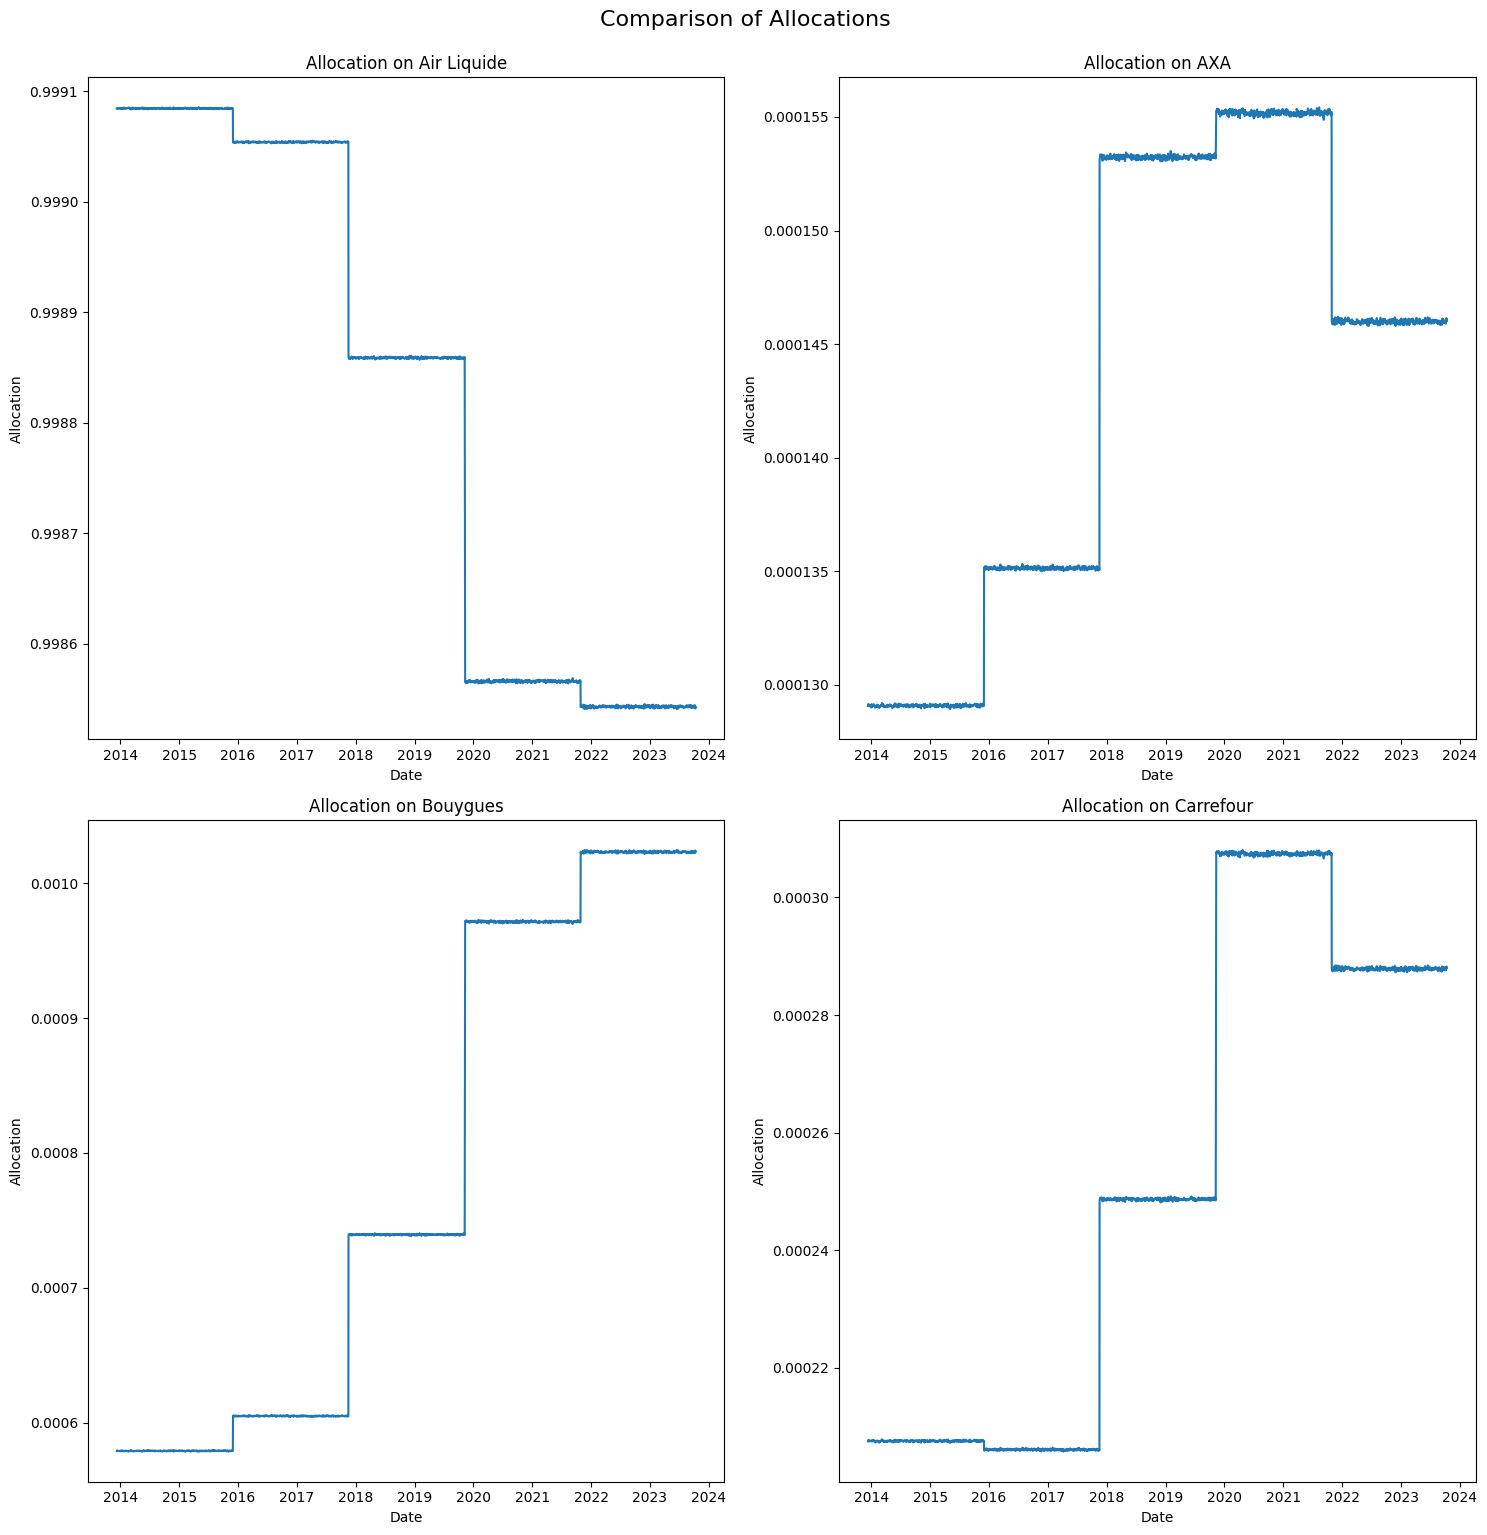

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

In [26]:
paper_results['cumulative_return']

Date
2013-12-10    1.014850
2013-12-11    1.014210
2013-12-12    1.037581
2013-12-13    1.036130
2013-12-16    1.037302
                ...   
2023-10-05    2.665652
2023-10-06    2.686355
2023-10-09    2.765490
2023-10-10    2.763106
2023-10-11    2.820689
Name: cumulative_return, Length: 2520, dtype: float64

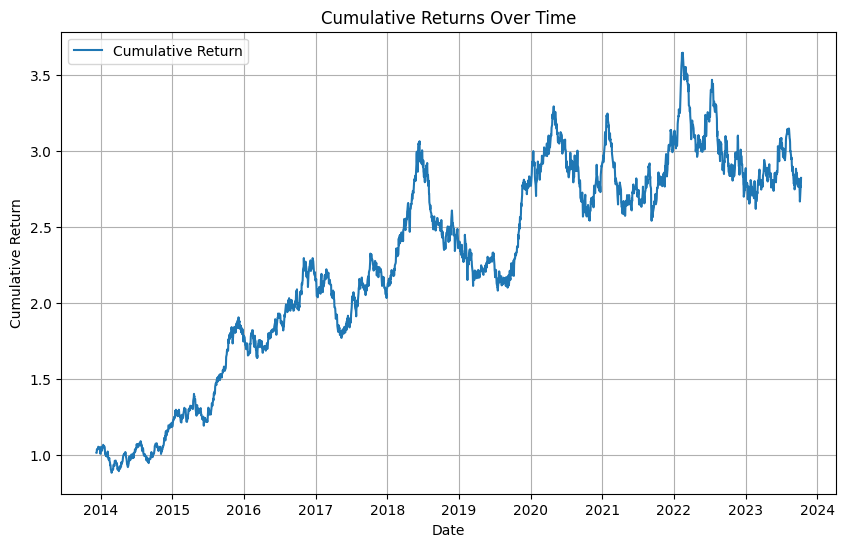

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# GRU with Overlapping

In [22]:
from models.base import NN_Sharpe
import torch 

input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [23]:
from models.utils import training_with_model

num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=True 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([957, 50, 4])
epoch 0, loss = -0.059228057786822316
epoch 1, loss = -0.0593555361032486
epoch 2, loss = -0.059477073202530546
epoch 3, loss = -0.05959411760171254
epoch 4, loss = -0.0597065418958664
epoch 5, loss = -0.05981439476211866
epoch 6, loss = -0.0599177435040474
epoch 7, loss = -0.060016695658365884
epoch 8, loss = -0.0601113793750604
epoch 9, loss = -0.06020195186138153
epoch 10, loss = -0.060288575539986296
epoch 11, loss = -0.060371426244576774
epoch 12, loss = -0.06045065894722938
epoch 13, loss = -0.06052642837166786
epoch 14, loss = -0.060598909358183545
epoch 15, loss = -0.060668248186508816
epoch 16, loss = -0.06073460504412651
epoch 17, loss = -0.060798128694295885
epoch 18, loss = -0.06085895995299021
epoch 19, loss = -0.06091725255052249
epoch 20, loss = -0.060973129918177923
epoch 21, loss = -0.06102672393123309
e

In [24]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.257453,0.243763,0.246797,0.251987,0.010398
2013-12-11,0.257453,0.243763,0.246797,0.251987,0.011443
2013-12-12,0.257453,0.243763,0.246797,0.251987,0.024889
2013-12-13,0.257453,0.243763,0.246797,0.251987,0.001961
2013-12-16,0.257453,0.243763,0.246797,0.251987,-0.004562
...,...,...,...,...,...
2023-10-05,0.257573,0.238631,0.252908,0.250889,-0.006348
2023-10-06,0.257573,0.238631,0.252908,0.250889,0.011580
2023-10-09,0.257573,0.238631,0.252908,0.250889,0.020582


In [25]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [26]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.257453,0.243763,0.246797,0.251987,0.010398,1.010398
2013-12-11,0.257453,0.243763,0.246797,0.251987,0.011443,1.021961
2013-12-12,0.257453,0.243763,0.246797,0.251987,0.024889,1.047396
2013-12-13,0.257453,0.243763,0.246797,0.251987,0.001961,1.049450
2013-12-16,0.257453,0.243763,0.246797,0.251987,-0.004562,1.044663
...,...,...,...,...,...,...
2023-10-05,0.257573,0.238631,0.252908,0.250889,-0.006348,1.386142
2023-10-06,0.257573,0.238631,0.252908,0.250889,0.011580,1.402194
2023-10-09,0.257573,0.238631,0.252908,0.250889,0.020582,1.431054


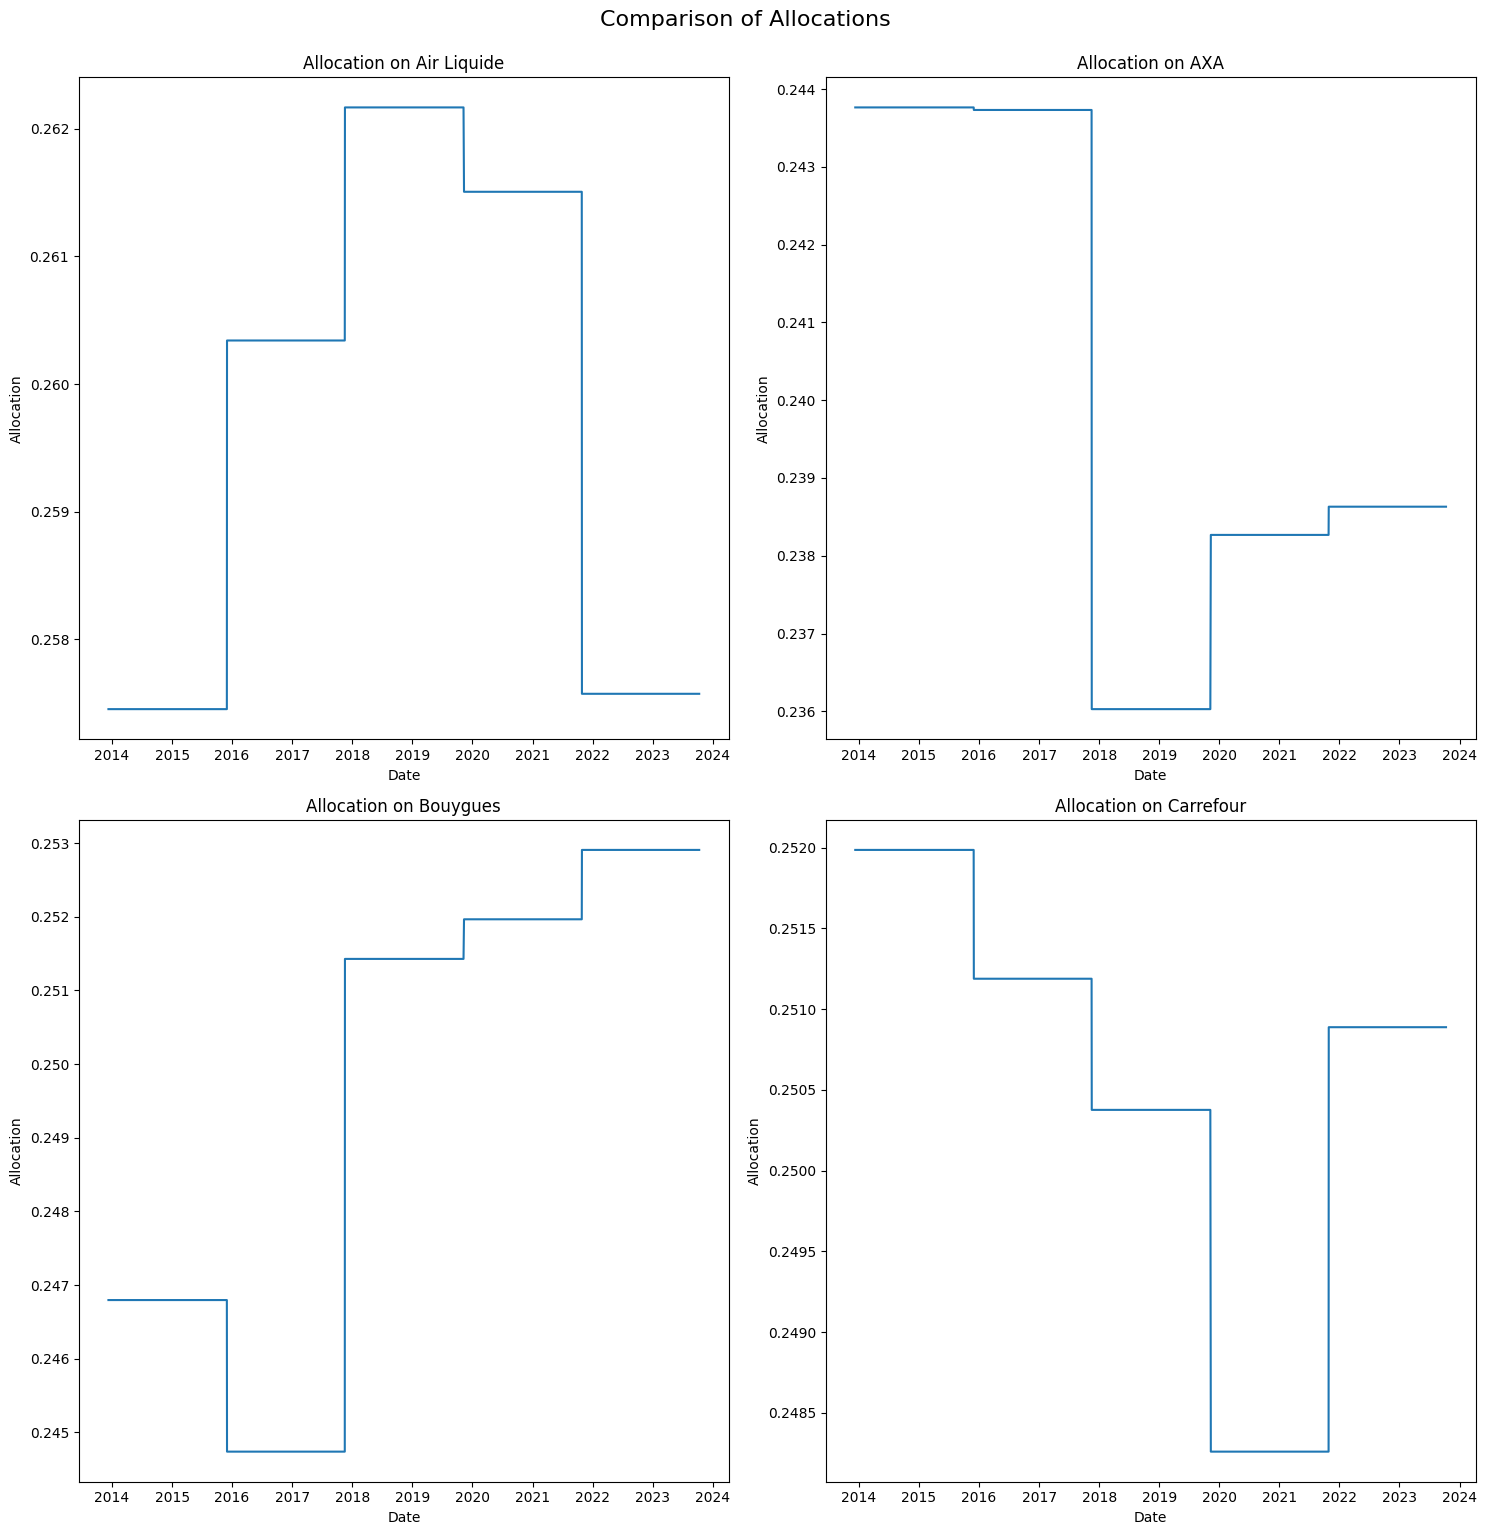

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

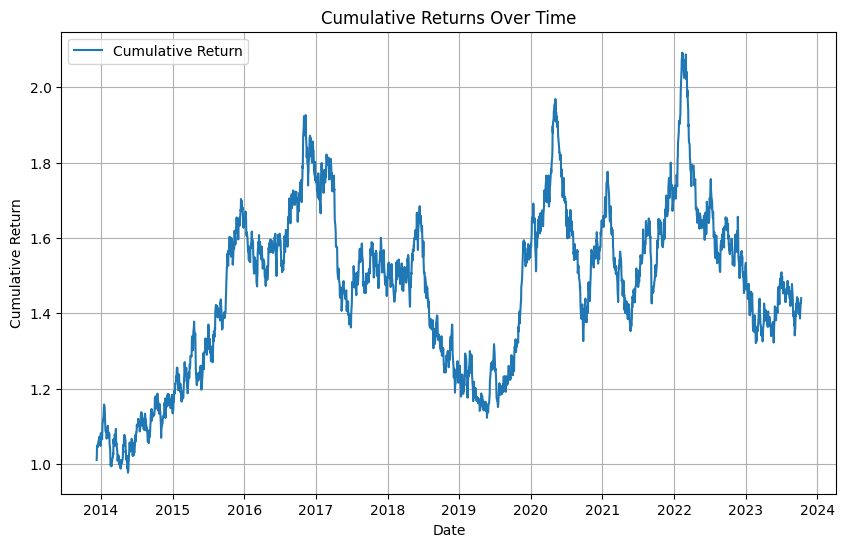

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# LSTM Without Overlapping

In [11]:
input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='LSTM'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0)


NameError: name 'NN_Sharpe' is not defined

In [30]:
num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.06209979206323624
epoch 1, loss = -0.0620969757437706
epoch 2, loss = -0.06209417060017586
epoch 3, loss = -0.06209136173129082
epoch 4, loss = -0.062088530510663986
epoch 5, loss = -0.062085676938295364
epoch 6, loss = -0.06208278611302376
epoch 7, loss = -0.06207987666130066
epoch 8, loss = -0.062076933681964874
epoch 9, loss = -0.06207394599914551
epoch 10, loss = -0.06207093596458435
epoch 11, loss = -0.0620679147541523
epoch 12, loss = -0.06206486374139786
epoch 13, loss = -0.062061797827482224
epoch 14, loss = -0.06205872818827629
epoch 15, loss = -0.06205564737319946
epoch 16, loss = -0.06205255910754204
epoch 17, loss = -0.06204947084188461
epoch 18, loss = -0.06204637885093689
epoch 19, loss = -0.06204327195882797
epoch 20, loss = -0.062040187418460846
epoch 21, loss = -0.062037087976932526
epo

In [31]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.257344,0.244537,0.248287,0.249832,0.010395
2013-12-11,0.257344,0.244538,0.248287,0.249832,0.011420
2013-12-12,0.257344,0.244538,0.248287,0.249832,0.024882
2013-12-13,0.257344,0.244538,0.248287,0.249832,0.001916
2013-12-16,0.257344,0.244538,0.248287,0.249832,-0.004612
...,...,...,...,...,...
2023-10-05,0.257793,0.242644,0.249018,0.250545,-0.006439
2023-10-06,0.257793,0.242644,0.249018,0.250545,0.011558
2023-10-09,0.257793,0.242644,0.249018,0.250545,0.020612


In [32]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [33]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.257344,0.244537,0.248287,0.249832,0.010395,1.010395
2013-12-11,0.257344,0.244538,0.248287,0.249832,0.011420,1.021934
2013-12-12,0.257344,0.244538,0.248287,0.249832,0.024882,1.047362
2013-12-13,0.257344,0.244538,0.248287,0.249832,0.001916,1.049369
2013-12-16,0.257344,0.244538,0.248287,0.249832,-0.004612,1.044529
...,...,...,...,...,...,...
2023-10-05,0.257793,0.242644,0.249018,0.250545,-0.006439,1.385961
2023-10-06,0.257793,0.242644,0.249018,0.250545,0.011558,1.401979
2023-10-09,0.257793,0.242644,0.249018,0.250545,0.020612,1.430877


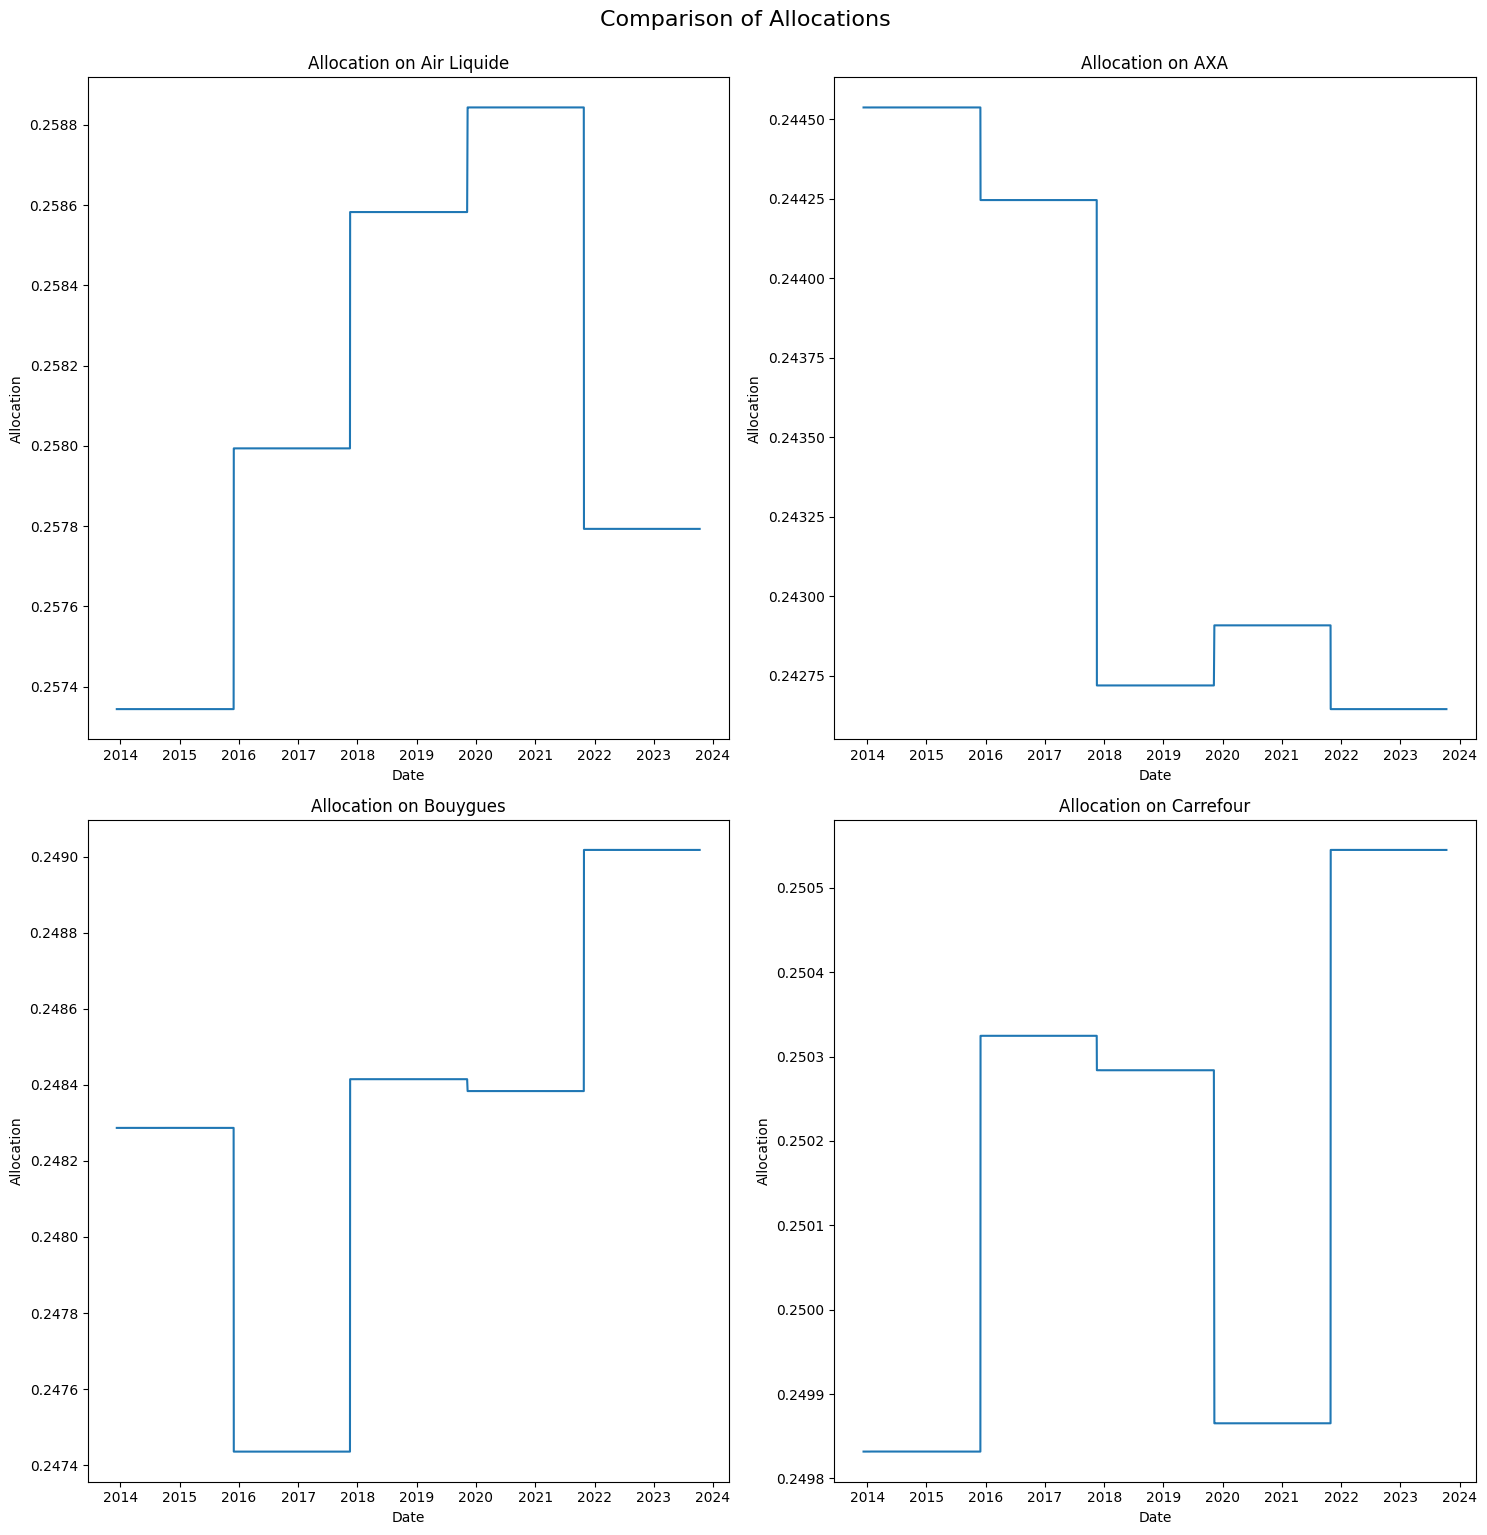

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

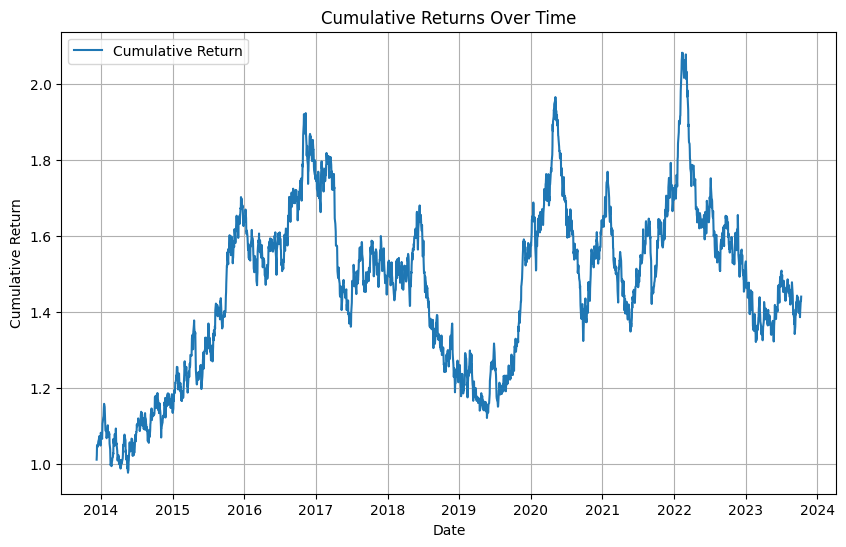

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# LSTM with overlapping 

In [36]:
input_size=4
hidden_size=64  
output_size=4  
num_layers=1  
model_name='GRU'

model = NN_Sharpe(input_size, hidden_size, output_size, num_layers, model_name)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.2)


In [37]:
num_simulations = simulated_returns.shape[1]  
dates = market_data.index[:simulated_returns.shape[0]]  

# Itérer sur chaque simulation
for i in range(num_simulations):
    # Extraire la simulation i
    single_simulation = simulated_returns[:, i, :]
    
    simulation_df = pd.DataFrame(single_simulation, columns=selected_tickers_names)
    simulation_df.index = dates[:len(simulation_df)]  
    
    print(f"Training on simulation {i + 1}/{num_simulations}...")

    # Entraîner le modèle sur cette simulation
    simulation_result = training_with_model(
        data_used=simulation_df.dropna(),  
        model=model, 
        optimizer=optimizer, 
        initial_train_years=4,  
        retrain_years=2,  
        rolling_window=50, 
        shuffle=False,  
        epoch=50,
        batch_size=64,  
        overlap=False 
    )

    #taking the final results 
    if(i==num_simulations-1):
        results = simulation_result
    



Training on simulation 1/10...
training from 2010-01-04 00:00:00 to 2013-12-10 00:00:00
invest from 2013-12-10 00:00:00 to 2015-12-01 00:00:00
torch.Size([20, 50, 4])
epoch 0, loss = -0.05730580538511276
epoch 1, loss = -0.05731352046132088
epoch 2, loss = -0.05732092261314392
epoch 3, loss = -0.057327620685100555
epoch 4, loss = -0.057333819568157196
epoch 5, loss = -0.05733977630734444
epoch 6, loss = -0.057345617562532425
epoch 7, loss = -0.057351481169462204
epoch 8, loss = -0.057357460260391235
epoch 9, loss = -0.05736362934112549
epoch 10, loss = -0.05736996605992317
epoch 11, loss = -0.057376403361558914
epoch 12, loss = -0.05738287419080734
epoch 13, loss = -0.05738932639360428
epoch 14, loss = -0.057395659387111664
epoch 15, loss = -0.05740184709429741
epoch 16, loss = -0.057407863438129425
epoch 17, loss = -0.057413749396800995
epoch 18, loss = -0.05741953104734421
epoch 19, loss = -0.057425253093242645
epoch 20, loss = -0.05743097513914108
epoch 21, loss = -0.057436745613813

In [38]:
results = results.dropna(how='any')
results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf
Date,,,,,
2013-12-10,0.256875,0.245352,0.247430,0.250343,0.010389
2013-12-11,0.256875,0.245352,0.247430,0.250343,0.011430
2013-12-12,0.256875,0.245352,0.247430,0.250343,0.024886
2013-12-13,0.256875,0.245352,0.247430,0.250343,0.001912
2013-12-16,0.256875,0.245352,0.247430,0.250343,-0.004609
...,...,...,...,...,...
2023-10-05,0.257470,0.243142,0.248485,0.250903,-0.006433
2023-10-06,0.257470,0.243142,0.248485,0.250903,0.011556
2023-10-09,0.257470,0.243142,0.248485,0.250903,0.020608


In [39]:
paper_results = results.copy()

paper_results['cumulative_return'] = (1 + paper_results['return_pf']).cumprod()



In [40]:
paper_results

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc,return_pf,cumulative_return
Date,,,,,,
2013-12-10,0.256875,0.245352,0.247430,0.250343,0.010389,1.010389
2013-12-11,0.256875,0.245352,0.247430,0.250343,0.011430,1.021937
2013-12-12,0.256875,0.245352,0.247430,0.250343,0.024886,1.047370
2013-12-13,0.256875,0.245352,0.247430,0.250343,0.001912,1.049372
2013-12-16,0.256875,0.245352,0.247430,0.250343,-0.004609,1.044535
...,...,...,...,...,...,...
2023-10-05,0.257470,0.243142,0.248485,0.250903,-0.006433,1.384787
2023-10-06,0.257470,0.243142,0.248485,0.250903,0.011556,1.400790
2023-10-09,0.257470,0.243142,0.248485,0.250903,0.020608,1.429658


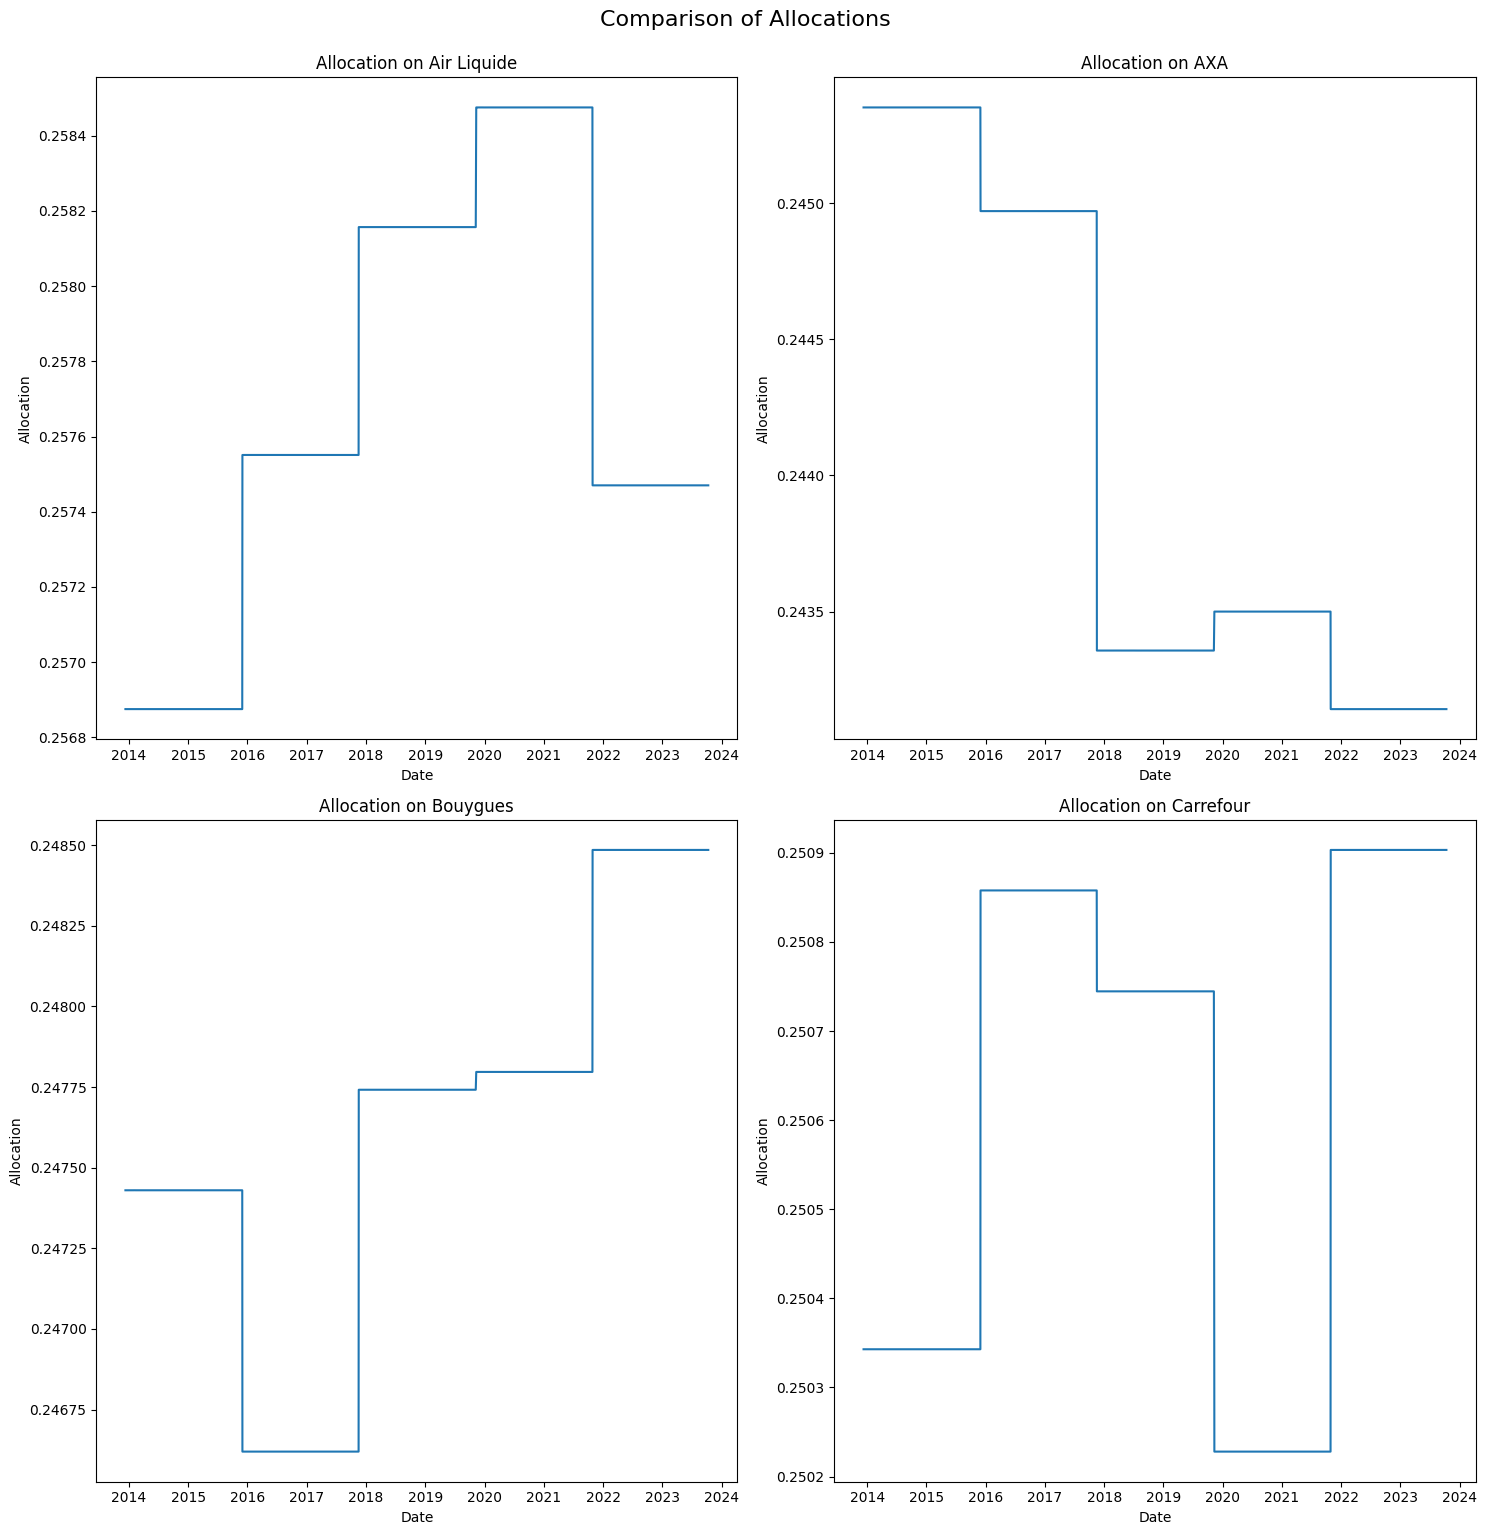

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axs = axs.flatten()

subplot_titles = [
    "Allocation on Air Liquide", "Allocation on AXA",
    "Allocation on Bouygues", "Allocation on Carrefour"
]

for i, ax in enumerate(axs):
    ax.set_title(subplot_titles[i])

# Allocation columns dictionary
allocations = {    
    'Air Liquide_alloc': 0,
    'AXA_alloc': 1,
    'Bouygues_alloc': 2,
    'Carrefour_alloc': 3
}

# Plot allocation for each asset
for alloc, ax_index in allocations.items():
    ax = axs[ax_index]
    if alloc in paper_results.columns:
        ax.plot(
            paper_results.index,
            paper_results[alloc],
            label=alloc,
        )
    ax.set_xlabel('Date')
    ax.set_ylabel('Allocation')

plt.tight_layout()
plt.suptitle("Comparison of Allocations", fontsize=16, y=1.02)
plt.show()

In [42]:
paper_results['cumulative_return']

Date
2013-12-10    1.010389
2013-12-11    1.021937
2013-12-12    1.047370
2013-12-13    1.049372
2013-12-16    1.044535
                ...   
2023-10-05    1.384787
2023-10-06    1.400790
2023-10-09    1.429658
2023-10-10    1.427245
2023-10-11    1.439028
Name: cumulative_return, Length: 2520, dtype: float64

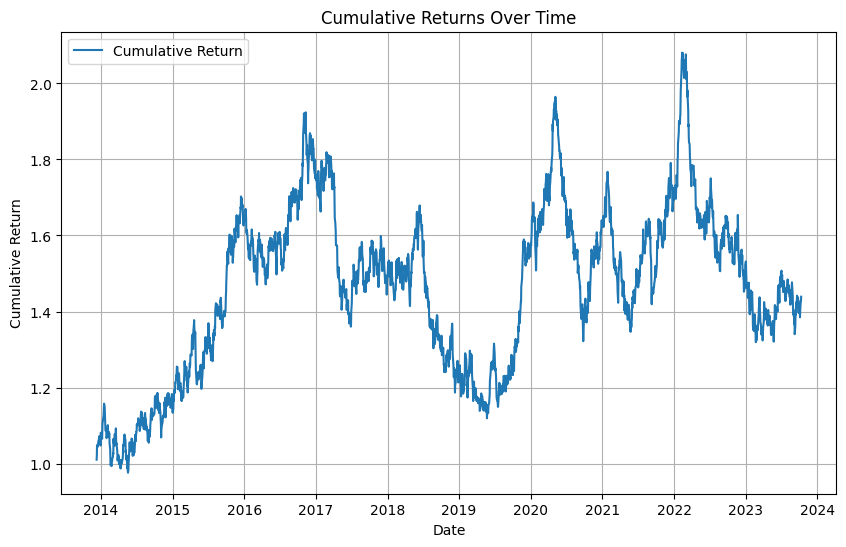

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(paper_results.index, paper_results['cumulative_return'], label='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Comparison with MV 

In [11]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   

In [12]:
def get_data(tickers, start_date, end_date):
    """Récupère les données historiques des actifs"""
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close']
    return data


def compute_rolling_volatility(value, window):
    """Calcule la volatilité glissante"""
    returns = np.diff(np.log(value), n=1, axis=0)
    volatility = np.lib.stride_tricks.sliding_window_view(
        returns, window_shape=window, axis=0
    ).std(axis=-1)
    return volatility * np.sqrt(252)

def calculate_portfolio_metrics(returns, weights):
    """Calcule les métriques du portefeuille"""
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = portfolio_return / portfolio_vol
    return portfolio_return, portfolio_vol, sharpe_ratio

def optimize_portfolio(returns, risk_free_rate=0):
    """Optimise le portefeuille selon Markowitz"""
    n = returns.shape[1]
    
    def objective(weights):
        portfolio_return, portfolio_vol, sharpe_ratio = calculate_portfolio_metrics(returns, weights)
        return -sharpe_ratio  # On maximise le ratio de Sharpe
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Somme des poids = 1
    )
    bounds = tuple((0, 1) for _ in range(n))  # Contraintes sur les poids
    initial_weights = np.array([1/n] * n)
    
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

def backtest_strategy(data, lookback=252, transaction_cost=0.0001):
    """Backteste la stratégie avec rebalancement journalier"""
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    portfolio_values = []
    weights_history = []
    current_weights = np.array([1/n_assets] * n_assets)
    
    # Initialisation
    portfolio_value = 1
    
    for t in range(lookback, len(returns)):
        # Données historiques pour l'optimisation
        historical_returns = returns.iloc[t-lookback:t]
        
        # Optimisation des nouveaux poids
        new_weights = optimize_portfolio(historical_returns)
        
        # Calcul des coûts de transaction
        trading_costs = np.sum(np.abs(new_weights - current_weights)) * transaction_cost
        
        # Mise à jour de la valeur du portefeuille
        daily_return = np.sum(returns.iloc[t] * current_weights) - trading_costs
        portfolio_value *= (1 + daily_return)
        
        portfolio_values.append(portfolio_value)
        weights_history.append(new_weights)
        current_weights = new_weights
    
    return portfolio_values, np.array(weights_history)


In [15]:
simulation_df

,Air Liquide,AXA,Bouygues,Carrefour
Date,,,,
2010-01-04,0.008007,-0.004320,-0.017991,-0.005073
2010-01-05,-0.008941,-0.011514,-0.009864,-0.009491
2010-01-06,-0.003728,0.004503,-0.005815,0.017480
2010-01-07,-0.021122,0.006588,-0.022041,-0.005926
2010-01-08,0.001304,0.008495,0.011200,0.029466
...,...,...,...,...
2024-12-13,0.002990,-0.030593,-0.002922,-0.003135
2024-12-16,0.010290,0.002944,-0.010451,-0.012607
2024-12-17,0.008116,-0.011929,-0.003083,0.007350


In [13]:
# Paramètres
#tickers = ['AGG', 'DBC', 'VTI', '^VIX']
#start_date = "2011-01-01"
#end_date = "2020-04-30"

# Récupération des données
#data = get_data(tickers, start_date, end_date)

# Backtest de la stratégie
portfolio_values, weights_history = backtest_strategy(simulation_df)

# Calcul des métriques finales
returns = pd.Series(portfolio_values).pct_change().dropna()
return_mean = returns.mean() * 252 * 100
volatility = returns.std() * np.sqrt(252) * 100
sharpe_ratio = return_mean / (volatility)

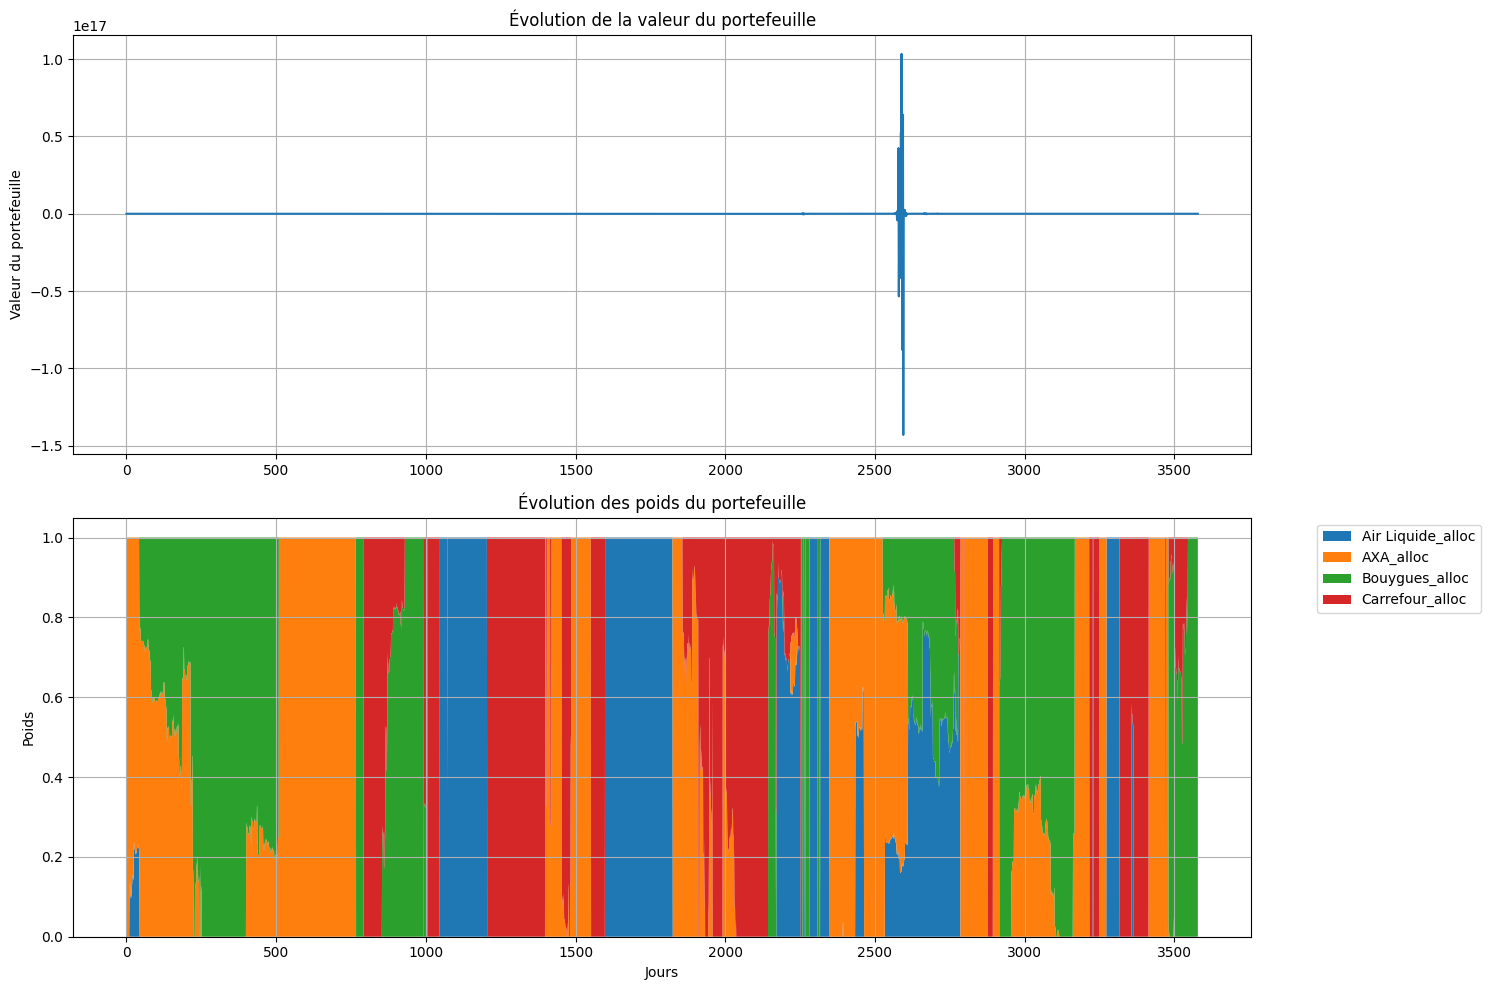

In [14]:
columns = ['Air Liquide_alloc', 'AXA_alloc', 'Bouygues_alloc', 'Carrefour_alloc']

plt.figure(figsize=(15, 10))

# Plot 1: Évolution de la valeur du portefeuille
plt.subplot(2, 1, 1)
plt.plot(portfolio_values)
plt.title('Évolution de la valeur du portefeuille')
plt.ylabel('Valeur du portefeuille')
plt.grid(True)

# Plot 2: Évolution des poids
plt.subplot(2, 1, 2)
weights_df = pd.DataFrame(weights_history, columns=columns)
plt.stackplot(range(len(weights_history)), weights_df.T, labels=columns)
plt.title('Évolution des poids du portefeuille')
plt.xlabel('Jours')
plt.ylabel('Poids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
weights_df

,Air Liquide_alloc,AXA_alloc,Bouygues_alloc,Carrefour_alloc
0,2.617595e-06,9.999974e-01,0.000000e+00,0.000000e+00
1,1.583504e-06,9.999984e-01,0.000000e+00,0.000000e+00
2,0.000000e+00,1.000000e+00,2.050828e-09,1.564668e-09
3,3.376723e-06,9.999967e-01,0.000000e+00,0.000000e+00
4,0.000000e+00,1.000000e+00,1.264307e-08,9.454943e-09
...,...,...,...,...
3575,6.130493e-16,0.000000e+00,1.000000e+00,2.885716e-15
3576,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
3577,0.000000e+00,3.150258e-15,1.000000e+00,0.000000e+00
3578,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00


Est-ce normal d'avoir très peu d'investissement sur les commodités ?

In [18]:
print(f"Performance totale: {return_mean:.2f}%")
print(f"Volatilité annualisée: {volatility:.2f}%")
print(f"Ratio de Sharpe: {sharpe_ratio:.2f}")

Performance totale: -26910.32%
Volatilité annualisée: 68272.22%
Ratio de Sharpe: -0.39


Comparé à l'article, l'espérance de rendement est cohérente, néanmoins la variance est presque deux fois inférieur à celle de l'article (10.8%). A quoi est due cette différence ?